# CSC 215 - Final Project

# Gender Classification with Deep Learning

## Khoi Hoang

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import time
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Helper function
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Manually load images

In [3]:
IMAGES_DIRECTORY = "C:/Users/hgdan/Downloads/lfw-deepfunneled/"

In [4]:
people = os.listdir(path=IMAGES_DIRECTORY)
print("There are {} people in the full lfw dataset.".format(len(people)))

There are 5749 people in the full lfw dataset.


In [5]:
image_array = []
for directory in os.listdir(IMAGES_DIRECTORY):
    image_dir = IMAGES_DIRECTORY + directory #go to sub directories
    for image in os.listdir(image_dir):
        image = plt.imread(os.path.join(image_dir, image))
        #image = cv2.resize(image, (100, 100))
        image_array.append(image)

In [6]:
image_array = np.array(image_array)
image_array.shape

(13233, 250, 250, 3)

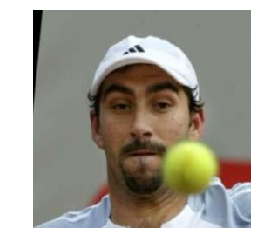

In [7]:
sample = 197

each = image_array[sample]

plt.figure()
plt.axis('off')
plt.imshow(each)
plt.show()

#### Making the gender labels for the output

In [8]:
df_male = pd.read_csv("gender_labels/male_names.txt")
df_female = pd.read_csv("gender_labels/female_names.txt")

In [9]:
df_female.head()

,Pics
0,Claudia_Coslovich_0001.jpg
1,Allison_Searing_0001
2,Elizabeth_Hill_0001.jpg
3,Erika_Reyes_0001.jpg
4,Tatiana_Shchegoleva_0001.jpg


In [10]:
# Helper function to convert the df into list of names for males or females
def gender_to_list(df):
    temp = df.values
    temp = temp.reshape(temp.shape[0],)
    
    res = []
    for each in temp:
        each = each.rsplit('_', 1)[0]
        res.append(each)
    
    return res

In [11]:
male = gender_to_list(df_male)
female = gender_to_list(df_female)

In [12]:
female[0:5]

['Claudia_Coslovich',
 'Allison_Searing',
 'Elizabeth_Hill',
 'Erika_Reyes',
 'Tatiana_Shchegoleva']

In [13]:
gender_target = []
for each in os.listdir(IMAGES_DIRECTORY): #iterate through the subdir
    if each in male:
        for i in range(len(os.listdir(IMAGES_DIRECTORY + each))):
            gender_target.append('male')
    elif each in female:
        for i in range(len(os.listdir(IMAGES_DIRECTORY + each))):
            gender_target.append('female')
    else:
        print(each)

In [14]:
gender_target = np.array(gender_target)
gender_target.shape

(13233,)

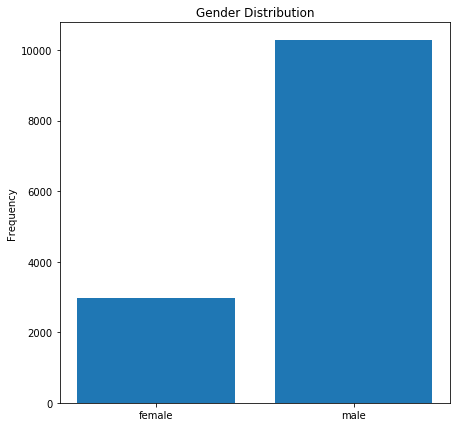

In [15]:
label, count_gender = np.unique(gender_target, return_counts=True)
y_pos = np.arange(2)
plt.figure(figsize=(7,7))
plt.bar(y_pos, count_gender, align='center')
plt.title("Gender Distribution")
plt.xticks(y_pos, label)
plt.ylabel("Frequency")
plt.show()

As we can see in the graph, the data is highly imbalanced. There are two ways to deal with imbalanced data:
  * Undersampling, we can reduce the number of male images to roughly 3k to balance the number of female images. However, this is not ideal because bigger data helps CNN train better
  * Oversampling, which is the technique I will apply in this project, is to increase the samples of imbalanced data. I will apply image augmentation on the female images to balance the male images

# Data balancing and Image Augmentation

In [16]:
female_images = []
male_images = []
for i in range(len(gender_target)):
    if gender_target[i] == 'female':
        female_images.append(image_array[i])
    else:
        male_images.append(image_array[i])
        
female_images = np.array(female_images)
male_images = np.array(male_images)
print(female_images.shape)
print(male_images.shape)

(2962, 250, 250, 3)
(10271, 250, 250, 3)


In [92]:
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

i=0
for batch in img_gen.flow(female_images, batch_size=1, 
                          save_to_dir="augmented",
                          save_format='jpg'):
    i+=1
    if i==7309:
        break
    

In [17]:
# read new augmented images
augmented_images = []
for image in os.listdir('augmented'):
    image = plt.imread(os.path.join('augmented/', image))
    augmented_images.append(image)

In [18]:
augmented_images = np.array(augmented_images)

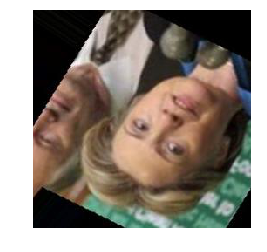

In [19]:
plt.figure()
plt.axis('off')
plt.imshow(augmented_images[197])
plt.show()

In [20]:
female_images = np.concatenate((female_images, augmented_images), axis=0)
female_images.shape

(10271, 250, 250, 3)

In [21]:
print("Number of male images: {}".format(male_images.shape[0]))
print("Number of female images: {}".format(female_images.shape[0]))

Number of male images: 10271
Number of female images: 10271


In [22]:
input_images = np.concatenate((male_images, female_images), axis=0)
output_label = np.zeros(input_images.shape[0])

In [23]:
# the first half is 0 (males), second half is 1 (females)
output_label[10271:] = 1

In order to train the data efficiently using the available memory, I resize the images to 100x100x3

In [24]:
# Resize the images
start = time.time()
input_images_resized = []
for each in input_images:
    each = cv2.resize(each, (100, 100))
    input_images_resized.append(each)

input_images_resized = np.array(input_images_resized)
print(input_images_resized.shape)
end = time.time()
print("Total time is {:0.2f}s".format(end-start))

(20542, 100, 100, 3)
Total time is 11.59s


# Deep CNN model

In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, UpSampling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, regularizers
from sklearn import metrics
from keras.optimizers import Adam, SGD
from keras.models import Model, load_model

Using TensorFlow backend.


In [26]:
x_train, x_test, y_train, y_test = train_test_split(input_images_resized, output_label, test_size=0.2, random_state=43)

In [27]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(16433, 100, 100, 3)
(16433,)
(4109, 100, 100, 3)
(4109,)


In [28]:
np.unique(y_test, return_counts=True)

(array([0., 1.]), array([2043, 2066], dtype=int64))

In [29]:
# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [30]:
y_train

array([1., 0., 1., ..., 1., 1., 1.])

In [31]:
# One hot encode the gender
y_train_tf = keras.utils.to_categorical(y_train, 2)
y_test_tf = keras.utils.to_categorical(y_test, 2)

In [32]:
y_test_tf.shape

(4109, 2)

In [49]:
checkpointer = ModelCheckpoint(filepath="save/deepcnn.hdf5", verbose=0, save_best_only=True) # save best model
input_shape = (100, 100, 3)
learning_rate = 0.001

#Build network
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=input_shape)) 
model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 98, 98, 96)        2688      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 96, 96, 96)        83040     
_________________________________________________________________
batch_normalization_10 (Batc (None, 96, 96, 96)        384       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 48, 48, 96)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 48, 48, 96)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 46, 46, 128)       110720    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 44, 44, 128)       147584    
__________

In [50]:
start = time.time()

history = model.fit(x_train,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],
                    verbose=1,epochs=50, batch_size=64, shuffle=True)      

end = time.time()
cnn_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_time/60.0))

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 42s 3ms/step - loss: 2.9555 - acc: 0.6684 - val_loss: 2.0178 - val_acc: 0.8026
Epoch 2/50
13146/13146 [==============================] - 37s 3ms/step - loss: 1.9223 - acc: 0.8012 - val_loss: 1.6698 - val_acc: 0.8245
Epoch 3/50
13146/13146 [==============================] - 37s 3ms/step - loss: 1.4759 - acc: 0.8646 - val_loss: 1.3131 - val_acc: 0.8972
Epoch 4/50
13146/13146 [==============================] - 37s 3ms/step - loss: 1.1620 - acc: 0.8986 - val_loss: 1.0933 - val_acc: 0.8655
Epoch 5/50
13146/13146 [==============================] - 38s 3ms/step - loss: 0.9477 - acc: 0.9145 - val_loss: 0.9334 - val_acc: 0.8911
Epoch 6/50
13146/13146 [==============================] - 37s 3ms/step - loss: 0.7731 - acc: 0.9261 - val_loss: 0.7038 - val_acc: 0.9346
Epoch 7/50
13146/13146 [==============================] - 37s 3ms/step - loss: 0.6536 - acc: 0.9353 - val_loss: 0.6610 - val_acc:

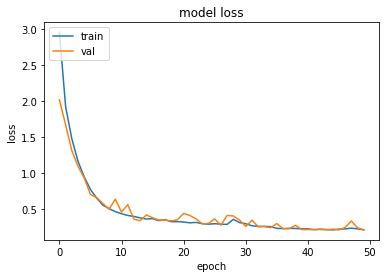

In [51]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
model = load_model('save/deepcnn.hdf5') # load weights from best model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 98, 98, 96)        2688      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 96, 96, 96)        83040     
_________________________________________________________________
batch_normalization_10 (Batc (None, 96, 96, 96)        384       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 48, 48, 96)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 48, 48, 96)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 46, 46, 128)       110720    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 44, 44, 128)       147584    
__________

-----------------Convolutional Neural Network Report---------------
F1 score: 0.9749332251768377
Accuracy score: 0.9749330737405695
Confusion matrix: 
 [[2000   43]
 [  60 2006]]
Plotting confusion matrix


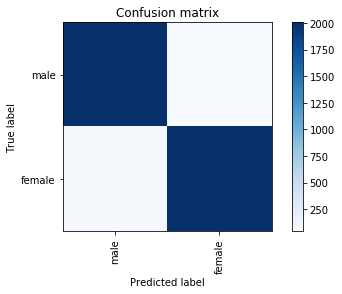

             precision    recall  f1-score   support

          0       0.97      0.98      0.97      2043
          1       0.98      0.97      0.97      2066

avg / total       0.97      0.97      0.97      4109



In [53]:
cnn_pred = model.predict(x_test)
cnn_pred = np.argmax(cnn_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

cnn_f1 = metrics.f1_score(y_true, cnn_pred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(y_true, cnn_pred)
cnn_cm = metrics.confusion_matrix(y_true, cnn_pred)
print("-----------------Convolutional Neural Network Report---------------")
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Confusion matrix: \n", cnn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, ["male", "female"])
plt.show()

print(metrics.classification_report(y_true, cnn_pred))

# CNN Embedding

As an attempt to reduce the training time while maintaining the performance of the model, I use supervised learning to train a shallow CNN model to extract the embedding features of the images. The embedding features are then feed into sklearn models such as Random Forest, SVM, KNN.

In [66]:
filepath = "save/cnn_embedding.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True) # save best model
input_shape = (100,100,3)
learning_rate = 0.0007

#Build network
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu', name='embedding_features'))
model.add(Dropout(0.5))
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 98, 98, 96)        2688      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 49, 49, 96)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 49, 49, 96)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 47, 47, 128)       110720    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 21, 21, 256)       295168    
__________

In [67]:
start = time.time()

history = model.fit(x_train,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    

end = time.time()
cnn_embedding_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_embedding_time/60.0))

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 25s 2ms/step - loss: 0.5404 - acc: 0.7013 - val_loss: 0.3386 - val_acc: 0.8351
Epoch 2/50
13146/13146 [==============================] - 21s 2ms/step - loss: 0.2969 - acc: 0.8685 - val_loss: 0.2493 - val_acc: 0.8832
Epoch 3/50
13146/13146 [==============================] - 20s 2ms/step - loss: 0.2364 - acc: 0.8964 - val_loss: 0.2000 - val_acc: 0.9188
Epoch 4/50
13146/13146 [==============================] - 21s 2ms/step - loss: 0.2029 - acc: 0.9165 - val_loss: 0.1580 - val_acc: 0.9367
Epoch 5/50
13146/13146 [==============================] - 21s 2ms/step - loss: 0.1831 - acc: 0.9250 - val_loss: 0.1390 - val_acc: 0.9501
Epoch 6/50
13146/13146 [==============================] - 21s 2ms/step - loss: 0.1541 - acc: 0.9365 - val_loss: 0.1220 - val_acc: 0.9516
Epoch 7/50
13146/13146 [==============================] - 21s 2ms/step - loss: 0.1497 - acc: 0.9415 - val_loss: 0.1207 - val_acc:

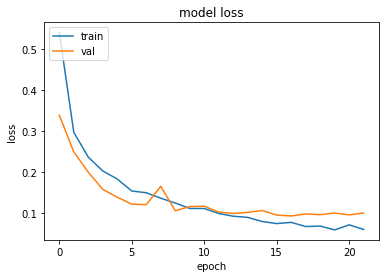

In [68]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [69]:
model = load_model('save/cnn_embedding.hdf5')
feature_model = Model(inputs=model.input, outputs=model.get_layer('embedding_features').output)

feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35_input (InputLayer) (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 98, 98, 96)        2688      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 49, 49, 96)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 49, 49, 96)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 47, 47, 128)       110720    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 23, 23, 128)       0         
__________

In [70]:
# Extracting the embedding features
embedding_features_train = feature_model.predict(x_train)
embedding_features_test = feature_model.predict(x_test)

In [71]:
embedding_features_test.shape

(4109, 2048)

# KNN model

In [72]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(embedding_features_train, y_train)

start = time.time()

y_pred_knn = knn.predict(embedding_features_test)

end = time.time()
knn_time = end-start
print("Total training time is {:0.2f} minute".format(knn_time/60.0))

Total training time is 0.62 minute


-----------------**K-nearest neighbors Report**---------------
F1 score: 0.9644677985060922
Accuracy score: 0.9644682404477976
Confusion matrix: 
 [[1985   58]
 [  88 1978]]
Plotting confusion matrix


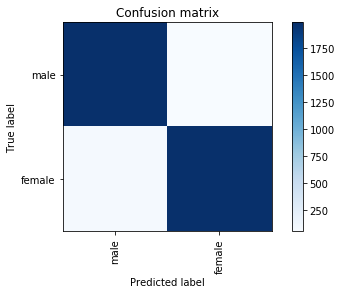

             precision    recall  f1-score   support

        0.0       0.96      0.97      0.96      2043
        1.0       0.97      0.96      0.96      2066

avg / total       0.96      0.96      0.96      4109



In [73]:
knn_f1 = metrics.f1_score(y_test, y_pred_knn, average= "weighted")
knn_accuracy = metrics.accuracy_score(y_test, y_pred_knn)
knn_cm = metrics.confusion_matrix(y_test, y_pred_knn)
print("-----------------**K-nearest neighbors Report**---------------")
print("F1 score: {}".format(knn_f1))
print("Accuracy score: {}".format(knn_accuracy))
print("Confusion matrix: \n", knn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(knn_cm, ['male', 'female'])
plt.show()

print(metrics.classification_report(y_test, y_pred_knn))

# Random Forest Model

In [74]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(criterion='entropy', max_depth=70, n_estimators=100)
start = time.time()

random_forest.fit(embedding_features_train, y_train)

end = time.time()
forest_time = end-start
print("Total training time is {:0.2f} minute".format(forest_time/60.0))

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Total training time is 0.23 minute


-----------------**Random Forest Report**---------------
F1 score: 0.963981550948325
Accuracy score: 0.9639815040155756
Confusion matrix: 
 [[1980   63]
 [  85 1981]]
Plotting confusion matrix


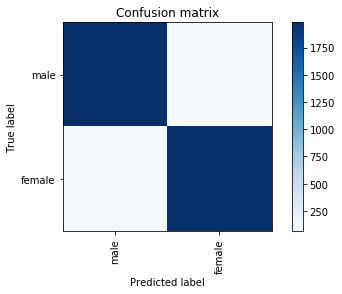

             precision    recall  f1-score   support

        0.0       0.96      0.97      0.96      2043
        1.0       0.97      0.96      0.96      2066

avg / total       0.96      0.96      0.96      4109



In [82]:
y_pred_forest = random_forest.predict(embedding_features_test)
random_forest_f1 = metrics.f1_score(y_test, y_pred_forest, average= "weighted")
random_forest_accuracy = metrics.accuracy_score(y_test, y_pred_forest)
random_forest_cm = metrics.confusion_matrix(y_test, y_pred_forest)
print("-----------------**Random Forest Report**---------------")
print("F1 score: {}".format(random_forest_f1))
print("Accuracy score: {}".format(random_forest_accuracy))
print("Confusion matrix: \n", random_forest_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(random_forest_cm, ['male', 'female'])
plt.show()

print(metrics.classification_report(y_test, y_pred_forest))

# SVM model

In [92]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 7, 10]}

start = time.time()

svc = SVC(gamma="auto")
clf = GridSearchCV(svc, parameters)
clf.fit(embedding_features_train, y_train)

end = time.time()
svm_time = end-start
print("Total training time is {:0.2f} minute".format(svm_time/60.0))

Total training time is 65.64 minute


In [93]:
print("Best parameters: {}".format(clf.best_params_))

Best parameters: {'C': 1, 'kernel': 'linear'}


-----------------**SVM Report**---------------
F1 score: 0.9661716015738844
Accuracy score: 0.9661718179605744
Confusion matrix: 
 [[1987   56]
 [  83 1983]]
Plotting confusion matrix


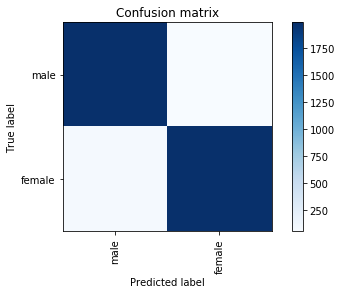

             precision    recall  f1-score   support

        0.0       0.96      0.97      0.97      2043
        1.0       0.97      0.96      0.97      2066

avg / total       0.97      0.97      0.97      4109



In [94]:
y_pred_svc = clf.predict(embedding_features_test)
svc_f1 = metrics.f1_score(y_test, y_pred_svc, average= "weighted")
svc_accuracy = metrics.accuracy_score(y_test, y_pred_svc)
svc_cm = metrics.confusion_matrix(y_test, y_pred_svc)
print("-----------------**SVM Report**---------------")
print("F1 score: {}".format(svc_f1))
print("Accuracy score: {}".format(svc_accuracy))
print("Confusion matrix: \n", svc_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(svc_cm, ['male', 'female'])
plt.show()

print(metrics.classification_report(y_test, y_pred_svc))

# Convolutional Autoencoder

In this section, I will use an autoencoder to extract important features from the images. 

In [33]:
filepath = "save/cnn_autoencoder.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True) # save best model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

input_size = (100, 100, 3)

input_image = Input(shape=input_size)

# Encoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded_layer')(x)
#x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)


# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), padding='same')(x)

autoencoder = Model(input_image, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       295040    
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       147584    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 50, 50, 128)       0         
__________

In [34]:
start = time.time()

history = autoencoder.fit(x_train,x_train, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    

end = time.time()
autoencoder_time = end-start
print("Total training time is {:0.2f} minute".format(autoencoder_time/60.0))

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 62s 5ms/step - loss: 0.0161 - val_loss: 0.0033
Epoch 2/50
13146/13146 [==============================] - 51s 4ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 3/50
13146/13146 [==============================] - 51s 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/50
13146/13146 [==============================] - 51s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/50
13146/13146 [==============================] - 51s 4ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/50
13146/13146 [==============================] - 51s 4ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/50
13146/13146 [==============================] - 51s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/50
13146/13146 [==============================] - 51s 4ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 9/50
13146/13146 [==============================] - 52s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 

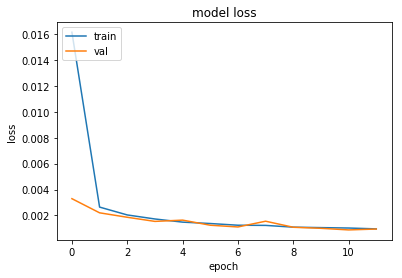

In [35]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [33]:
model = load_model('save/cnn_autoencoder.hdf5')
encoder_feature = Model(inputs=model.input, outputs=model.get_layer('encoded_layer').output)

encoder_feature.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       295040    
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 25, 25, 128)       0         
Total params: 302,208
Trainable params: 302,208
Non-trainable params: 0
_________________________________________________________________


In [34]:
autoencoder_features_train = encoder_feature.predict(x_train)
autoencoder_features_test = encoder_feature.predict(x_test)

In [35]:
autoencoder_features_train.shape

(16433, 25, 25, 128)

# CNN with autoencoder extracted features

In [54]:
filepath = "save/cnn_with_autoencoder.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True) # save best model
input_shape = (25, 25, 128)
learning_rate = 0.001

#Build network
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape)) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='embedding_features'))
model.add(Dropout(0.5))
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 23, 23, 128)       147584    
_________________________________________________________________
batch_normalization_10 (Batc (None, 23, 23, 128)       512       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 256)         295168    
_________________________________________________________________
batch_normalization_11 (Batc (None, 9, 9, 256)         1024      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 256)         0         
__________

In [55]:
start = time.time()

history = model.fit(autoencoder_features_train,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    

end = time.time()
cnn_autoencoder_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_autoencoder_time/60.0))

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 11s 837us/step - loss: 0.7075 - acc: 0.6871 - val_loss: 0.4170 - val_acc: 0.8156
Epoch 2/50
13146/13146 [==============================] - 10s 738us/step - loss: 0.3323 - acc: 0.8525 - val_loss: 0.4305 - val_acc: 0.7928
Epoch 3/50
13146/13146 [==============================] - 10s 740us/step - loss: 0.2495 - acc: 0.8966 - val_loss: 0.3560 - val_acc: 0.8503
Epoch 4/50
13146/13146 [==============================] - 11s 846us/step - loss: 0.2129 - acc: 0.9167 - val_loss: 0.2939 - val_acc: 0.8783
Epoch 5/50
13146/13146 [==============================] - 9s 720us/step - loss: 0.1975 - acc: 0.9223 - val_loss: 0.2558 - val_acc: 0.8820
Epoch 6/50
13146/13146 [==============================] - 9s 700us/step - loss: 0.1818 - acc: 0.9269 - val_loss: 0.2453 - val_acc: 0.8841
Epoch 7/50
13146/13146 [==============================] - 9s 719us/step - loss: 0.1744 - acc: 0.9330 - val_loss: 0.6158

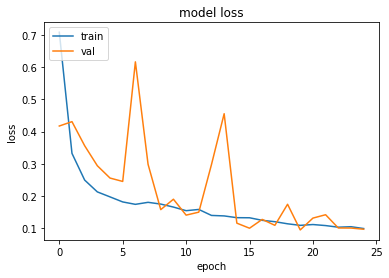

In [56]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

-----------------**Convolutional Neural Network Report**---------------
F1 score: 0.9642220113032774
Accuracy score: 0.9642248722316865
Confusion matrix: 
 [[1956   87]
 [  60 2006]]
Plotting confusion matrix


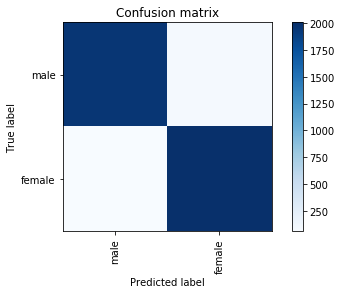

             precision    recall  f1-score   support

          0       0.97      0.96      0.96      2043
          1       0.96      0.97      0.96      2066

avg / total       0.96      0.96      0.96      4109



In [57]:
cnn_autoencoder_pred = model.predict(autoencoder_features_test)
cnn_autoencoder_pred = np.argmax(cnn_autoencoder_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

cnn_autoencoder_f1 = metrics.f1_score(y_true, cnn_autoencoder_pred, average= "weighted")
cnn_autoencoder_accuracy = metrics.accuracy_score(y_true, cnn_autoencoder_pred)
cnn_autoencoder_cm = metrics.confusion_matrix(y_true, cnn_autoencoder_pred)
print("-----------------**Convolutional Neural Network Report**---------------")
print("F1 score: {}".format(cnn_autoencoder_f1))
print("Accuracy score: {}".format(cnn_autoencoder_accuracy))
print("Confusion matrix: \n", cnn_autoencoder_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_autoencoder_cm, ["male", "female"])
plt.show()

print(metrics.classification_report(y_true, cnn_autoencoder_pred))

# Transfer learning with VGG16

In [35]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(100,100,3))

In [36]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [37]:
vgg16.output_shape[1]

3

In [38]:
learning_rate = 0.001

for layer in vgg16.layers[:11]:
    layer.trainable = False
    
input_shape = vgg16.output_shape[1]

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(2, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total para

In [74]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg16.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [68]:
filepath = "save/vgg16_transfer.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True) # save best model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

start = time.time()

history = model.fit(x_train,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    

end = time.time()
vgg16_time = end-start
print("Total training time is {:0.2f} minute".format(vgg16_time/60.0))

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 34s 3ms/step - loss: 0.5255 - acc: 0.7013 - val_loss: 0.4944 - val_acc: 0.8372
Epoch 2/50
13146/13146 [==============================] - 27s 2ms/step - loss: 0.1628 - acc: 0.9388 - val_loss: 0.1488 - val_acc: 0.9422
Epoch 3/50
13146/13146 [==============================] - 26s 2ms/step - loss: 0.1037 - acc: 0.9624 - val_loss: 0.1033 - val_acc: 0.9553
Epoch 4/50
13146/13146 [==============================] - 25s 2ms/step - loss: 0.0883 - acc: 0.9690 - val_loss: 0.1324 - val_acc: 0.9547
Epoch 5/50
13146/13146 [==============================] - 25s 2ms/step - loss: 0.0746 - acc: 0.9738 - val_loss: 0.1137 - val_acc: 0.9626
Epoch 6/50
13146/13146 [==============================] - 26s 2ms/step - loss: 0.0968 - acc: 0.9655 - val_loss: 0.1313 - val_acc: 0.9595
Epoch 7/50
13146/13146 [==============================] - 26s 2ms/step - loss: 0.0601 - acc: 0.9789 - val_loss: 0.0874 - val_acc:

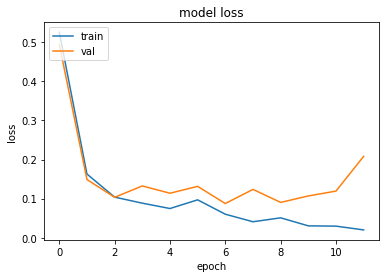

In [69]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

-----------------**Transfer Learning Report**---------------
F1 score: 0.9732294169465693
Accuracy score: 0.9732294962277926
Confusion matrix: 
 [[1987   56]
 [  54 2012]]
Plotting confusion matrix


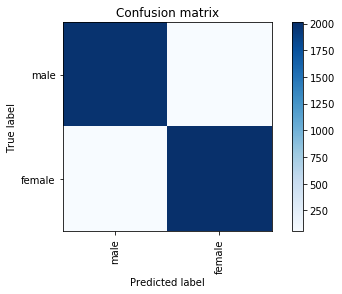

             precision    recall  f1-score   support

          0       0.97      0.97      0.97      2043
          1       0.97      0.97      0.97      2066

avg / total       0.97      0.97      0.97      4109



In [39]:
model.load_weights("save/vgg16_transfer.hdf5")
vgg16_transfer_pred = model.predict(x_test)
vgg16_transfer_pred = np.argmax(vgg16_transfer_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

vgg16_transfer_f1 = metrics.f1_score(y_true, vgg16_transfer_pred, average= "weighted")
vgg16_transfer_accuracy = metrics.accuracy_score(y_true, vgg16_transfer_pred)
vgg16_transfer_cm = metrics.confusion_matrix(y_true, vgg16_transfer_pred)
print("-----------------**Transfer Learning Report**---------------")
print("F1 score: {}".format(vgg16_transfer_f1))
print("Accuracy score: {}".format(vgg16_transfer_accuracy))
print("Confusion matrix: \n", vgg16_transfer_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(vgg16_transfer_cm, ["male", "female"])
plt.show()

print(metrics.classification_report(y_true, vgg16_transfer_pred))

In [43]:
gender_label = {0.0 : "Male", 1.0 : "Female"}

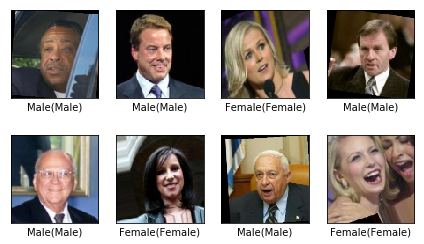

In [84]:
# Sample Prediction
ROW = 2
COLUMN = 4
#plt.figure(figsize=(9, 9)) 
for i in range(ROW * COLUMN):
    temp = random.randint(0, len(x_test)+1)
    image = x_test[temp] 
    plt.subplot(ROW, COLUMN, i+1)       
    plt.imshow(image)  
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(gender_label[np.argmax(model.predict(np.expand_dims(x_test[temp], axis=0)))] + "(" + gender_label[y_test[temp]] + ")")
    plt.tight_layout()   
    
plt.show()

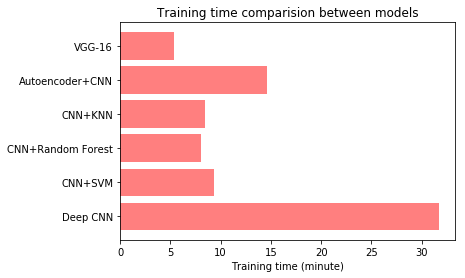

In [89]:
labels = ('Deep CNN', 'CNN+SVM', 'CNN+Random Forest', 'CNN+KNN', 'Autoencoder+CNN', 'VGG-16')
y_pos = np.arange(len(labels))
training_time = [31.72, 9.38, 8.09, 8.48, 14.6, 5.39]

plt.barh(y_pos, training_time, align='center', alpha=0.5, color='red')
plt.yticks(y_pos, labels)
plt.xlabel('Training time (minute)')
plt.title('Training time comparision between models')

plt.show()